# HARLF Implementation - Part 2: Sentiment Analysis & Environment Setup

This is the second milestone in the HARLF implementation pipeline. We build upon the data collection from Part 1 to create a comprehensive sentiment analysis and environment setup for reinforcement learning.

## Key Components
- **Sentiment Analysis Pipeline**: FinBERT-based sentiment extraction from financial news
- **NLP Feature Engineering**: Transform raw sentiment scores into ML-ready features  
- **Environment Setup**: Create reinforcement learning environment for portfolio management
- **Data Preparation**: Split data into training and testing sets
- **Validation**: Test environment functionality and data consistency



In [1]:
# Cell 2: Imports and Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from transformers import pipeline
import gymnasium as gym
from gymnasium import spaces
import pickle

from utile import *

## 2. Data Loading and Initialization

Load preprocessed data from Part 1 of the HARLF pipeline:

- **Price Data**: Monthly price series for selected assets
- **Returns Data**: Calculated monthly returns  
- **Technical Indicators**: RSI, MACD, Bollinger Bands, etc.
- **Asset Configuration**: List of selected financial instruments
- **Date Parameters**: Training and testing period boundaries

This step ensures data continuity between notebook milestones.


In [2]:
# Load data from previous notebook
print("Loading data from Part 1...")
monthly_prices = pd.read_pickle('outputs/monthly_prices.pkl')
monthly_returns = pd.read_pickle('outputs/monthly_returns.pkl')
technical_indicators = pd.read_pickle('outputs/technical_indicators.pkl')
with open('outputs/assets.pkl', 'rb') as f:
    ASSETS = pickle.load(f)
with open('outputs/date_params.pkl', 'rb') as f:
    date_params = pickle.load(f)

TRAIN_START = date_params['train_start']
TRAIN_END = date_params['train_end']
TEST_START = date_params['test_start']
TEST_END = date_params['test_end']


print("Data loaded successfully!")
print(f"Monthly prices shape: {monthly_prices.shape}")
print(f"Monthly prices date range: {monthly_prices.index.min().strftime('%Y-%m-%d')} to {monthly_prices.index.max().strftime('%Y-%m-%d')}")
print(f"Technical indicators shape: {technical_indicators.shape}")
print(f"Technical indicators date range: {technical_indicators.index.min().strftime('%Y-%m-%d')} to {technical_indicators.index.max().strftime('%Y-%m-%d')}")

Loading data from Part 1...
Data loaded successfully!
Monthly prices shape: (272, 17)
Monthly prices date range: 2003-01-31 to 2025-08-31
Technical indicators shape: (271, 221)
Technical indicators date range: 2003-02-28 to 2025-08-31


## 3. Data Alignment and Preprocessing

Ensure all datasets share consistent date indices for proper feature alignment:

- **Index Synchronization**: Align price and technical indicator data to common dates
- **Data Validation**: Verify shapes and date ranges match across datasets
- **Quality Check**: Confirm no missing periods that could affect model training

This prevents dimension mismatches during feature engineering and model training.


In [3]:
# Fix date alignment issue
print("\n=== Fixing Date Alignment ===")

# Align all data to the same date index (technical_indicators has the correct range)
common_dates = technical_indicators.index
monthly_prices = monthly_prices.loc[common_dates]
monthly_returns = monthly_returns.loc[common_dates]

print(f"After alignment:")
print(f"Monthly prices data range: {monthly_prices.index.min().strftime('%Y-%m-%d')} to {monthly_prices.index.max().strftime('%Y-%m-%d')}")
print(f"Monthly prices shape: {monthly_prices.shape}")

print(f"Technical indicators data range: {technical_indicators.index.min().strftime('%Y-%m-%d')} to {technical_indicators.index.max().strftime('%Y-%m-%d')}")
print(f"Technical indicators shape: {technical_indicators.shape}")


=== Fixing Date Alignment ===
After alignment:
Monthly prices data range: 2003-02-28 to 2025-08-31
Monthly prices shape: (271, 17)
Technical indicators data range: 2003-02-28 to 2025-08-31
Technical indicators shape: (271, 221)


## 4. Sentiment Analysis Pipeline

Execute the core sentiment analysis workflow using FinBERT:

- **Model Setup**: Initialize FinBERT transformer model for financial sentiment analysis
- **Data Collection**: Extract sentiment scores for each asset over the time period
- **Feature Engineering**: Transform raw sentiment data into normalized NLP features
- **Integration**: Combine sentiment features with technical indicators

The sentiment pipeline provides crucial market sentiment context for the RL agent's decision-making process.


In [4]:
#Execute Sentiment Analysis and Environment Setup
print("=== Starting Sentiment Analysis Pipeline ===")

# Set up sentiment analysis
sentiment_analyzer = setup_sentiment_analysis()

# Collect sentiment data
sentiment_data = collect_sentiment_data(ASSETS, technical_indicators)

# Create NLP features
nlp_features = create_nlp_features(sentiment_data, technical_indicators)

=== Starting Sentiment Analysis Pipeline ===
Setting up FinBERT sentiment analysis...


Device set to use cpu


✓ FinBERT loaded successfully
Sentiment data shape: (271, 17)
Creating NLP-driven features...
NLP features shape: (271, 34)


In [5]:
nlp_features.tail()

,nlp_feature_0,nlp_feature_1,nlp_feature_2,nlp_feature_3,nlp_feature_4,nlp_feature_5,nlp_feature_6,nlp_feature_7,nlp_feature_8,nlp_feature_9,...,nlp_feature_24,nlp_feature_25,nlp_feature_26,nlp_feature_27,nlp_feature_28,nlp_feature_29,nlp_feature_30,nlp_feature_31,nlp_feature_32,nlp_feature_33
Date,,,,,,,,,,,,,,,,,,,,,
2025-04-30,0.9464,0.4209,0.9373,0.2190,0.6465,0.3107,0.4328,0.0596,0.0150,0.4904,...,0.683911,0.601073,0.772471,0.685832,0.497142,0.721422,0.735592,0.621402,0.460415,0.781557
2025-05-31,0.9494,0.4624,1.0000,0.2728,0.6320,0.4178,0.4407,0.0393,0.0314,0.4835,...,0.726449,0.532255,0.661466,0.436857,0.604303,0.288662,0.666361,0.569303,0.656675,0.747661
2025-06-30,0.9862,0.4304,0.9844,0.3545,0.6973,0.4191,0.4089,0.0171,0.1073,0.4530,...,0.475736,0.559796,0.646547,0.600848,0.371872,0.625276,0.569956,0.433123,0.599568,0.495690
2025-07-31,0.9844,0.4117,0.9336,0.3794,0.6644,0.4191,0.4676,0.0166,0.1513,0.4438,...,0.495463,0.670575,0.600266,0.560296,0.645985,0.254444,0.634602,0.573649,0.627706,0.583578
2025-08-31,1.0000,0.4092,0.9263,0.3652,0.6423,0.3623,0.4209,0.0000,0.1086,0.4415,...,0.452314,0.524476,0.836386,0.567873,0.612006,0.443524,0.586537,0.428608,0.512669,0.573988


## 5. Train/Test Data Splitting

Split the dataset into training and testing periods using temporal boundaries:

- **Training Period**: Historical data for agent learning (earlier time period)
- **Testing Period**: Out-of-sample data for performance evaluation (later time period)
- **Consistency Check**: Ensure all feature sets maintain the same temporal splits
- **Validation**: Verify data integrity across train/test boundaries

Proper temporal splitting prevents data leakage and ensures realistic backtesting conditions.


In [6]:
print("\n=== Data Splitting TRAIN/TEST ===")

# Split data into train/test periods using proper date filtering
train_mask = (monthly_prices.index >= TRAIN_START) & (monthly_prices.index <= TRAIN_END)
test_mask = (monthly_prices.index >= TEST_START) & (monthly_prices.index <= TEST_END)

print(f"Train mask sum: {train_mask.sum()}")
print(f"Test mask sum: {test_mask.sum()}")

# Apply masks to all datasets
train_prices = monthly_prices[train_mask]
test_prices = monthly_prices[test_mask]

train_features = technical_indicators[train_mask]
test_features = technical_indicators[test_mask]

train_sentiment = nlp_features[train_mask] if nlp_features is not None else None
test_sentiment = nlp_features[test_mask] if nlp_features is not None else None

print(f"Train period: {len(train_prices)} months ({train_prices.index.min().strftime('%Y-%m-%d')} to {train_prices.index.max().strftime('%Y-%m-%d')})")
print(f"Test period: {len(test_prices)} months ({test_prices.index.min().strftime('%Y-%m-%d')} to {test_prices.index.max().strftime('%Y-%m-%d')})")

# Verify all datasets have consistent shapes
print(f"\nData consistency check:")
print(f"Train prices: {train_prices.shape}")
print(f"Train features: {train_features.shape}")
print(f"Train sentiment: {train_sentiment.shape if train_sentiment is not None else 'None'}")
print(f"Test prices: {test_prices.shape}")
print(f"Test features: {test_features.shape}")
print(f"Test sentiment: {test_sentiment.shape if test_sentiment is not None else 'None'}")


=== Data Splitting TRAIN/TEST ===
Train mask sum: 179
Test mask sum: 91
Train period: 179 months (2003-02-28 to 2017-12-31)
Test period: 91 months (2018-01-31 to 2025-07-31)

Data consistency check:
Train prices: (179, 17)
Train features: (179, 221)
Train sentiment: (179, 34)
Test prices: (91, 17)
Test features: (91, 221)
Test sentiment: (91, 34)


## 6. Reinforcement Learning Environment Setup

Create and validate the HARLF portfolio management environment:

- **Environment Initialization**: Create RL environments for both technical and sentiment features
- **Space Definition**: Configure action and observation spaces for portfolio allocation
- **Functionality Testing**: Validate environment reset, step, and reward mechanisms
- **Integration Test**: Ensure proper data flow between environment and feature sets

The environment serves as the interface between the RL agent and the financial market simulation.


In [7]:
# Environment Creation and Testing
print("\n=== Environment Setup ===")

# Create environments
env_data = HARLFPortfolioEnv(train_prices, train_features, train_period=True)
env_nlp = HARLFPortfolioEnv(train_prices, train_sentiment, train_period=True) if train_sentiment is not None else None

print("Environments created successfully")

# Test environment functionality
print("\n=== Testing Environment ===")
obs, info = env_data.reset()
print(f"Observation shape: {obs.shape}")
print(f"Action space: {env_data.action_space}")
print(f"Observation space: {env_data.observation_space}")

# Random action test
action = env_data.action_space.sample()
obs, reward, terminated, truncated, info = env_data.step(action)
print(f"Step result - Reward: {reward:.4f}, Portfolio Value: ${info['portfolio_value']:,.2f}")
print(f"Terminated: {terminated}, Truncated: {truncated}")



=== Environment Setup ===
Environment initialized with 179 time steps
Environment initialized with 179 time steps
Environments created successfully

=== Testing Environment ===
Observation shape: (221,)
Action space: Box(0.0, 1.0, (17,), float32)
Observation space: Box(-inf, inf, (221,), float32)
Step result - Reward: -0.0162, Portfolio Value: $99,459.81
Terminated: False, Truncated: False


## 7. Data Quality Visualization

Create comprehensive visualizations to assess data quality and feature relationships:

- **Sentiment Trends**: Time series plots of sentiment scores for key assets
- **Feature Correlations**: Heatmap analysis of NLP feature interdependencies  
- **Distribution Analysis**: Histograms comparing technical indicators, sentiment, and NLP features

These visualizations provide crucial insights into data quality and feature engineering effectiveness before model training.



=== Creating Visualizations ===


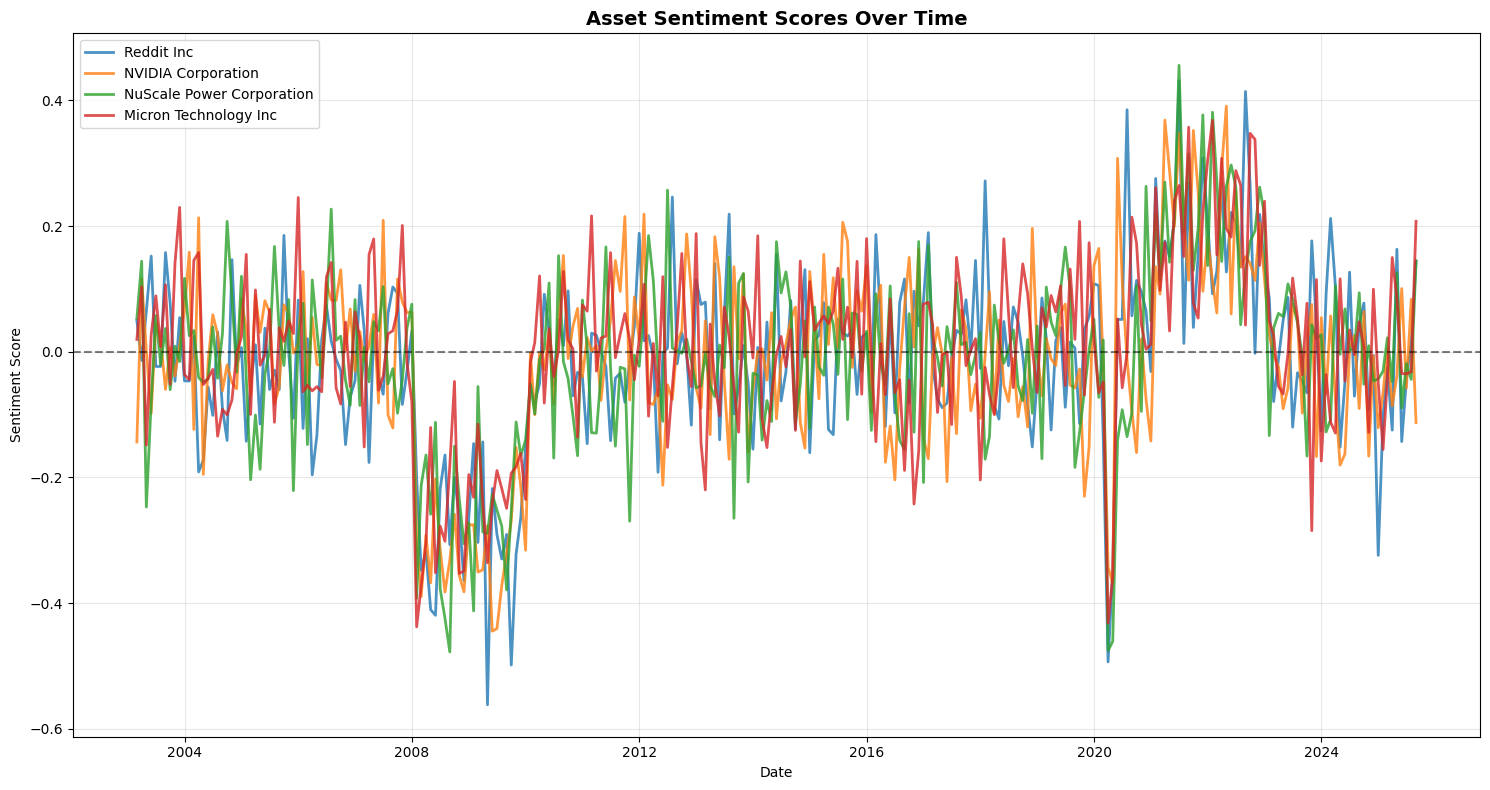

In [8]:
# Visualizations
print("\n=== Creating Visualizations ===")

# Sentiment trends visualization
plt.figure(figsize=(15, 8))

# Plot sentiment for selected assets (first 4)
selected_assets = list(ASSETS.keys())[:4]
for asset in selected_assets:
    if asset in sentiment_data.columns:
        plt.plot(sentiment_data.index, sentiment_data[asset], 
                label=ASSETS[asset], alpha=0.8, linewidth=2)

plt.title('Asset Sentiment Scores Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

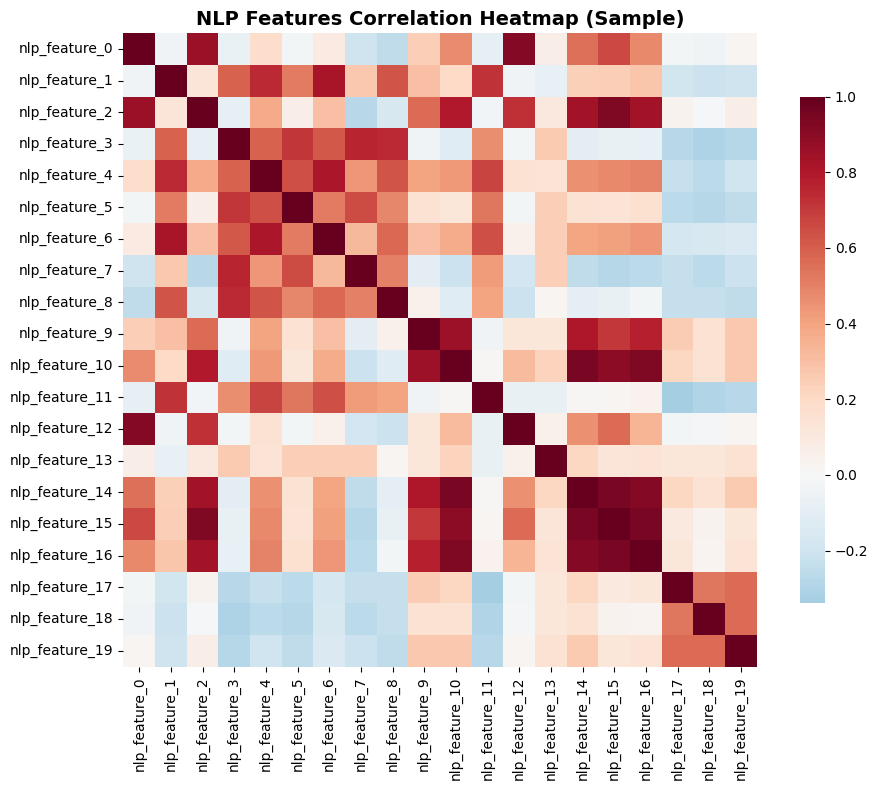

In [9]:
# NLP Features correlation heatmap
plt.figure(figsize=(10, 8))
# Sample features to avoid overcrowding
sample_nlp = nlp_features.iloc[:, :20] if nlp_features.shape[1] > 20 else nlp_features
corr_matrix = sample_nlp.corr()
sns.heatmap(corr_matrix, center=0, cmap='RdBu_r', square=True, 
            cbar_kws={"shrink": .8})
plt.title('NLP Features Correlation Heatmap (Sample)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

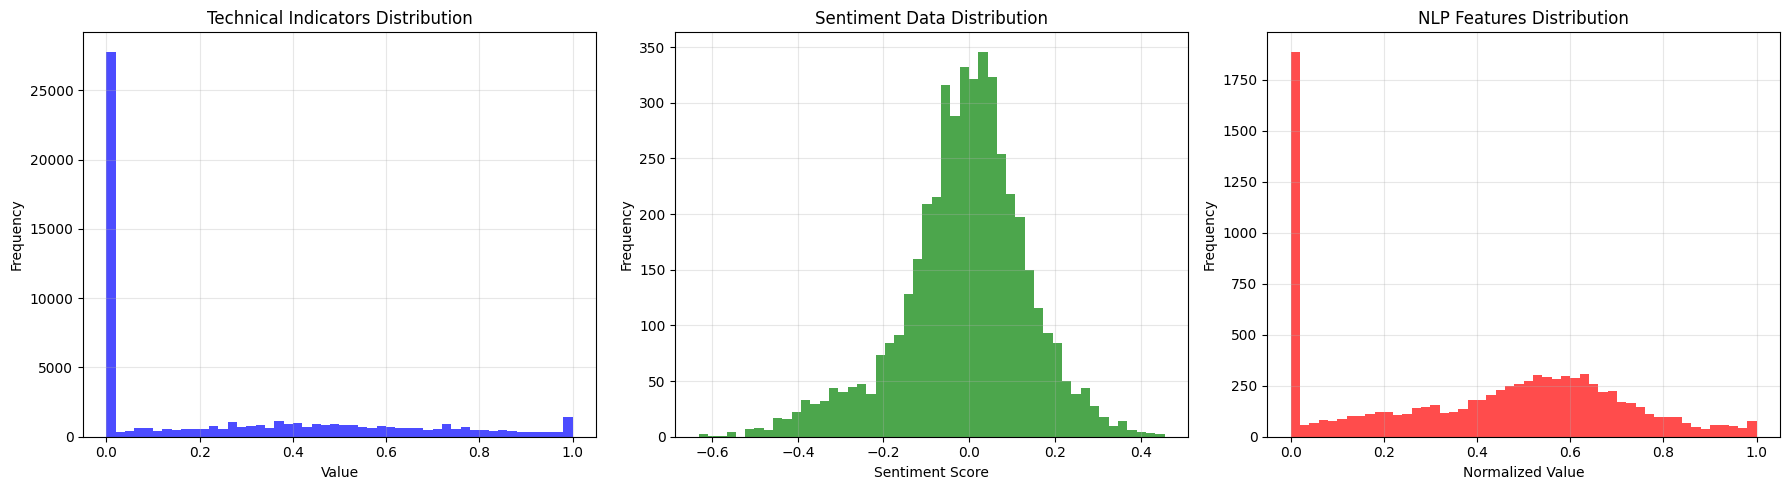

In [10]:
# Data distribution comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Technical indicators distribution
axes[0].hist(technical_indicators.values.flatten(), bins=50, alpha=0.7, color='blue')
axes[0].set_title('Technical Indicators Distribution')
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Frequency')
axes[0].grid(True, alpha=0.3)

# Sentiment data distribution
axes[1].hist(sentiment_data.values.flatten(), bins=50, alpha=0.7, color='green')
axes[1].set_title('Sentiment Data Distribution')
axes[1].set_xlabel('Sentiment Score')
axes[1].set_ylabel('Frequency')
axes[1].grid(True, alpha=0.3)

# NLP features distribution
axes[2].hist(nlp_features.values.flatten(), bins=50, alpha=0.7, color='red')
axes[2].set_title('NLP Features Distribution')
axes[2].set_xlabel('Normalized Value')
axes[2].set_ylabel('Frequency')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [11]:
# Save all processed data
sentiment_data.to_pickle('outputs/sentiment_data.pkl')
nlp_features.to_pickle('outputs/nlp_features.pkl')

# Save train/test splits
train_prices.to_pickle('outputs/train_prices.pkl')
test_prices.to_pickle('outputs/test_prices.pkl')
train_features.to_pickle('outputs/train_features.pkl')
test_features.to_pickle('outputs/test_features.pkl')

if train_sentiment is not None:
    train_sentiment.to_pickle('outputs/train_sentiment.pkl')
if test_sentiment is not None:
    test_sentiment.to_pickle('outputs/test_sentiment.pkl')

# Save environment class for next notebook
import dill
with open('outputs/environment_class.pkl', 'wb') as f:
    dill.dump(HARLFPortfolioEnv, f)

print("Data saved successfully!")

Data saved successfully!


## 8. Data Serialization and Export

Save all processed data and configurations for the next pipeline stage:

- **Processed Features**: Sentiment data and NLP features for model input
- **Train/Test Splits**: Organized datasets ready for agent training and evaluation
- **Environment Class**: Serialized environment for consistent RL setup
- **Validation**: Confirm all critical components are properly saved

Data persistence ensures seamless transition to the agent training phase (Part 3).


In [12]:

print("SENTIMENT ANALYSIS & ENVIRONMENT SETUP COMPLETE")

print(f"\nData Processing Results:")
print(f"   • Sentiment data: {sentiment_data.shape}")
print(f"   • NLP features: {nlp_features.shape}")
print(f"   • Training samples: {len(train_prices)}")
print(f"   • Testing samples: {len(test_prices)}")

print(f"\nEnvironment Configuration:")
print(f"   • Assets: {len(ASSETS)}")
print(f"   • Action space: {env_data.action_space}")
print(f"   • Observation space: {env_data.observation_space.shape}")
print(f"   • Time steps: {len(env_data.common_dates)}")

print(f"\nFiles Created:")
print(f"   • sentiment_data.pkl")
print(f"   • nlp_features.pkl")
print(f"   • train_prices.pkl, test_prices.pkl")
print(f"   • train_features.pkl, test_features.pkl")
print(f"   • train_sentiment.pkl, test_sentiment.pkl")
print(f"   • environment_class.pkl")

print(f"\nReady for notebook 03_agent_training.ipynb")


SENTIMENT ANALYSIS & ENVIRONMENT SETUP COMPLETE

Data Processing Results:
   • Sentiment data: (271, 17)
   • NLP features: (271, 34)
   • Training samples: 179
   • Testing samples: 91

Environment Configuration:
   • Assets: 17
   • Action space: Box(0.0, 1.0, (17,), float32)
   • Observation space: (221,)
   • Time steps: 179

Files Created:
   • sentiment_data.pkl
   • nlp_features.pkl
   • train_prices.pkl, test_prices.pkl
   • train_features.pkl, test_features.pkl
   • train_sentiment.pkl, test_sentiment.pkl
   • environment_class.pkl

Ready for notebook 03_agent_training.ipynb


## 9. Pipeline Reflection and Quality Assessment

### Implementation Success
This notebook successfully establishes the sentiment analysis and environment infrastructure for the HARLF system. Key achievements include:

- **Robust Data Pipeline**: Seamless integration between data collection (Part 1) and sentiment processing
- **Feature Engineering**: Transformation of raw sentiment scores into ML-ready NLP features
- **Environment Validation**: Confirmed RL environment functionality with proper action/observation spaces
- **Data Quality Assurance**: Comprehensive visualizations validate feature distributions and correlations

### Technical Considerations
- **Sentiment Model**: FinBERT provides domain-specific financial sentiment analysis
- **Feature Scaling**: NLP features are properly normalized for neural network training
- **Temporal Consistency**: Proper train/test splitting maintains temporal integrity
- **Environment Design**: HARLF environment follows Gymnasium standards for RL compatibility

### Potential Areas for Improvement
- **Error Handling**: Additional validation for missing data or model failures
- **Feature Selection**: Correlation analysis could guide feature dimensionality reduction  
- **Sentiment Validation**: Real-world sentiment data comparison for model accuracy assessment
- **Performance Monitoring**: Memory and computational efficiency tracking for large datasets

### Next Steps
The pipeline is ready for Part 3 (Agent Training) with all necessary components properly configured and validated.
